In [7]:
import os
import av
import torch
import numpy as np
import torch.nn.functional as F
from transformers import AutoImageProcessor, TimesformerForVideoClassification
from collections import defaultdict
from tqdm.notebook import tqdm

# 加载模型和图像处理器
model = TimesformerForVideoClassification.from_pretrained("facebook/timesformer-base-finetuned-k400")
image_processor = AutoImageProcessor.from_pretrained("MCG-NJU/videomae-base-finetuned-kinetics")

# 读取视频列表和标签，并按类别组织
video_labels = defaultdict(list)
with open("archive/kinetics400_val_list_videos.txt", "r") as f:
    for line in f:
        name, label = line.strip().split()
        video_labels[int(label)].append(name)

def split_video_into_segments(container, n_segments=8, frames_per_segment=16):
    frames = []
    frame_list = []
    # 从容器中读取所有帧
    for frame in container.decode(video=0):
        frame_list.append(frame.to_image())
    
    total_frames = len(frame_list)
    segment_length = total_frames // n_segments

    # 分割帧到不同的段中
    for i in range(n_segments):
        start_index = i * segment_length
        end_index = start_index + segment_length
        if i == n_segments - 1:
            # 确保最后一个段包括所有剩余的帧
            end_index = total_frames
        segment_frames = frame_list[start_index:end_index]
        
        # 如果段中帧数不足，重复最后一帧至足够数量
        while len(segment_frames) < frames_per_segment:
            segment_frames.append(segment_frames[-1])
        
        # 取每个段的前 frames_per_segment 帧以确保一致性
        frames.append(segment_frames[:frames_per_segment])
    
    return frames

def predict_segment(model, image_processor, video_segment):
    inputs = image_processor(list(video_segment), return_tensors="pt")
    inputs = {k: v.to('cuda') for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probabilities = F.softmax(logits, dim=-1)
        predicted_label = logits.argmax(-1).item()
        prediction_score = probabilities[0, predicted_label].item()
    
    return predicted_label, prediction_score

def predict_labels(sampled_files, true_labels):
    predictions = []
    model.to('cuda')
    for video_file in tqdm(sampled_files, desc="Processing videos", unit="video"):
        file_path = os.path.join("archive/videos_val", video_file)
        container = av.open(file_path)
        video_segments = split_video_into_segments(container)
        video_predictions = [predict_segment(model, image_processor, segment) for segment in video_segments]
        predictions.append(video_predictions)

    return predictions

# 准备视频样本
num_samples_per_class = 5  # 测试时减少样本量以加速过程
sampled_files, true_labels = list(video_labels.items())[0][1][:num_samples_per_class], [list(video_labels.keys())[0]] * num_samples_per_class
predictions = predict_labels(sampled_files, true_labels)

# 打印输出每个视频每个段的预测结果
for video_file, video_preds in zip(sampled_files, predictions):
    print(f"Video: {video_file}")
    for i, (label, score) in enumerate(video_preds):
        print(f"  Segment {i+1}: Predicted Label = {label}, Score = {score:.4f}")


/home/z/miniconda3/envs/mmxai/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Processing videos:   0%|          | 0/5 [00:00<?, ?video/s]

Video: jf7RDuUTrsQ.mp4
  Segment 1: Predicted Label = 81, Score = 0.4557
  Segment 2: Predicted Label = 171, Score = 0.6322
  Segment 3: Predicted Label = 1, Score = 0.5045
  Segment 4: Predicted Label = 289, Score = 0.4299
  Segment 5: Predicted Label = 1, Score = 0.4968
  Segment 6: Predicted Label = 127, Score = 0.4740
  Segment 7: Predicted Label = 57, Score = 0.3964
  Segment 8: Predicted Label = 81, Score = 0.4700
Video: EhRxb8-cNzQ.mp4
  Segment 1: Predicted Label = 230, Score = 0.5502
  Segment 2: Predicted Label = 230, Score = 0.6382
  Segment 3: Predicted Label = 106, Score = 0.3546
  Segment 4: Predicted Label = 122, Score = 0.1118
  Segment 5: Predicted Label = 149, Score = 0.9921
  Segment 6: Predicted Label = 149, Score = 0.8774
  Segment 7: Predicted Label = 127, Score = 0.5743
  Segment 8: Predicted Label = 149, Score = 0.3811
Video: l2_Da-CMPfY.mp4
  Segment 1: Predicted Label = 302, Score = 0.9208
  Segment 2: Predicted Label = 302, Score = 0.6358
  Segment 3: Predict

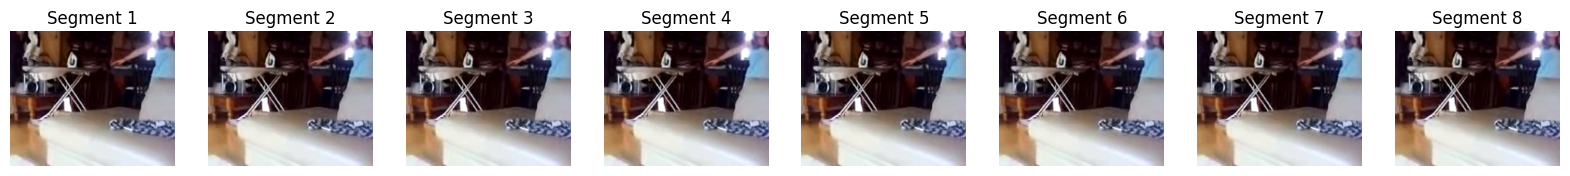

In [6]:
import matplotlib.pyplot as plt

def visualize_segments(video_segments):
    fig, axs = plt.subplots(1, len(video_segments), figsize=(20, 4))
    for i, segment in enumerate(video_segments):
        axs[i].imshow(segment[0])  # 显示每个段的第一帧
        axs[i].set_title(f"Segment {i+1}")
        axs[i].axis('off')
    plt.show()

# 选择一个视频文件进行测试
file_path = os.path.join("archive/videos_val", sampled_files[1])
container = av.open(file_path)
video_segments = split_video_into_segments(container)

# 可视化分段
visualize_segments(video_segments)
